### Lecture 2, f0 detection using Essentia - Melodia and Crepe:

[Extended Colab version of [Lecture2_step2_EssPreDomMel.ipynb](https://github.com/MTG/MIRCourse/blob/master/notebooks/Lecture2_step2_EssPreDomMel.ipynb) ]

In this example, we demonstrate use of the predominant melody extraction function of Essentia, discuss the influence of analysis parameter choice on the estimated pitch info and also demonstrate use of [mir_eval](https://github.com/craffel/mir_eval) library to evaluate its performance. 

There is no student version of this notebook

In [ ]:
!pip install essentia crepe mir_eval mirdata

     |████████████████████████████████| 13.7 MB 4.8 MB/s 
     |████████████████████████████████| 87 kB 5.8 MB/s 
     |████████████████████████████████| 13.1 MB 39.5 MB/s 
     |████████████████████████████████| 374 kB 70.0 MB/s 
     |████████████████████████████████| 5.6 MB 30.7 MB/s 
     |████████████████████████████████| 51 kB 61 kB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 
  Created wheel for crepe: filename=crepe-0.0.12-py3-none-any.whl size=134848696 sha256=d072040f575ce6c82a97bf0899ff16e76ccf959fd1ab768f9143b61509804509
  Stored in directory: /root/.cache/pip/wheels/56/05/32/fccf64e8ae720b34b486b6a8a08712777fd0beab419980fea3
  Created wheel for mir-eval: filename=mir_eval-0.6-py3-none-any.whl size=96515 sha256=9bf71e1f497cc5a70205f3ba476d077d9a32f62e98e8fb41184d287597e29361
  Stored in directory: /root/.cache/pip/wheels/08/28/2d/006dbad29550bac8daf049ff34fa882655a7d3e77f3b67595e
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size

In [ ]:
import os
from essentia import *
from essentia.standard import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import get_window
import soundfile as sf
import urllib.request
from IPython.display import Audio

In [ ]:
url = 'https://github.com/MTG/MIRCourse/raw/master/data/baris/eh.wav'
fileName = url.split('/')[-1]
urllib.request.urlretrieve(url,fileName)
x, fs = sf.read(fileName)
x = x / np.max(np.abs(x))#amplitude normalisation
print('Sampling frequency: ', fs, 'Hz')
minF0 = 50 #in Hz
maxF0 = 2000 #in Hz
windowSize = 4096
hopSize = 1024
w = get_window('blackman', windowSize)
startIndexes = np.arange(0, x.size - windowSize, hopSize, dtype = int)
numWindows = startIndexes.size
Audio(x, rate=fs)

Sampling frequency:  44100 Hz


In [ ]:
run_predominant_melody = PitchMelodia(guessUnvoiced = True,
                                      frameSize = windowSize,
                                      hopSize = hopSize,
                                      maxFrequency = 2000,
                                      minFrequency = 50,
                                      sampleRate = fs);

#x = EqualLoudness()(x)
f0, confidence = run_predominant_melody(x)

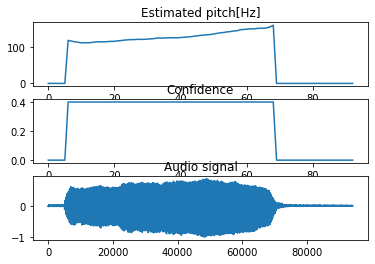

In [ ]:
#Plotting estimated pitch, confidence with audio
f, axarr = plt.subplots(3)
axarr[0].plot(f0)
axarr[0].set_title('Estimated pitch[Hz]')
axarr[1].plot(confidence)
axarr[1].set_title('Confidence')
axarr[2].plot(x)
axarr[2].set_title('Audio signal')
plt.show()

In [ ]:
#Saving estimated values to file
fileNameF0 = fileName.replace('.wav','.f0_preDomMel.txt')
startIndexes = np.arange(0, x.size - windowSize, hopSize, dtype = int)
with open(fileNameF0, 'w') as f:
    for k in range(startIndexes.size):
        time = (startIndexes[k] + windowSize / 2) / fs
        f.write(str(time) + '\t' + str(f0[k]) + '\n')

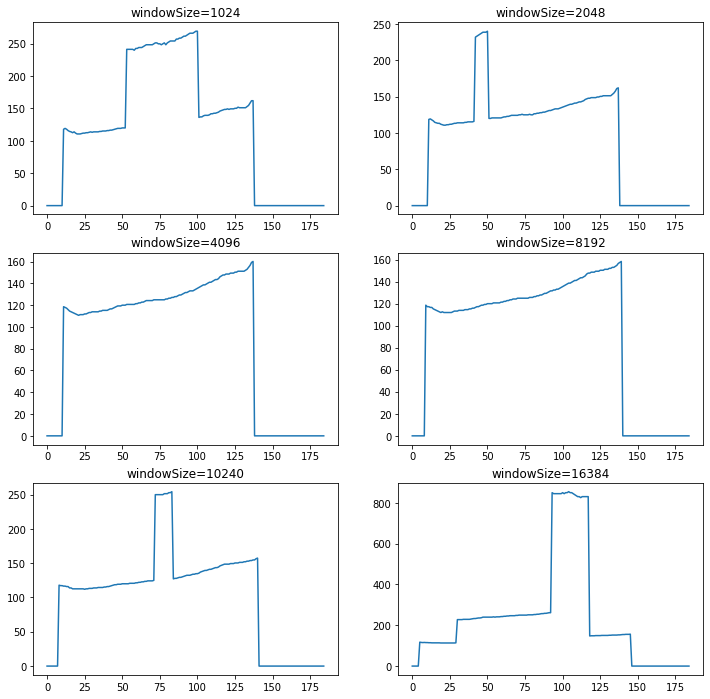

In [ ]:
#Demonstrating influence of parameters in estimation
winSizeValues = np.array([1,2,4,8,10,16])*1024
numFrm2plot = len(winSizeValues)
plt.figure(figsize = (12, numFrm2plot * 2))
plotInd = 1
hopSize = 1024//2
for windowSize in winSizeValues:
    run_predominant_melody = PitchMelodia(guessUnvoiced = True, frameSize = int(windowSize), hopSize = hopSize, sampleRate = fs);
    f0, confidence = run_predominant_melody(x)
    plt.subplot(numFrm2plot / 2, 2, plotInd)
    plt.plot(f0)
    plt.title('windowSize=' + str(windowSize))
    plotInd += 1

### Let's now evaluate Essentia's performance on a file from a dataset:

We will use [mir-eval](https://github.com/craffel/mir_eval) Python library ([documentation](http://craffel.github.io/mir_eval/)) presented in:
Colin Raffel, Brian McFee, Eric J. Humphrey, Justin Salamon, Oriol Nieto, Dawen Liang, and Daniel P. W. Ellis, ["mir_eval: A Transparent Implementation of Common MIR Metrics"](http://colinraffel.com/publications/ismir2014mir_eval.pdf), Proceedings of the 15th International Conference on Music Information Retrieval, 2014.

File resource: https://labrosa.ee.columbia.edu/projects/melody/ , you could also use files in this package:
https://labrosa.ee.columbia.edu/projects/melody/mirex05TrainFiles.zip


In [ ]:
#This cell downloads a few samples for analysis
import urllib.request
import zipfile
import os, sys,shutil

main_data_dir = 'data'
if not os.path.exists(main_data_dir):#creating the directory if not exist
    os.mkdir(main_data_dir)

targetDir = os.path.join(main_data_dir,'melody')
if not os.path.exists(targetDir):#creating the director
    os.mkdir(targetDir)

#Link for example files on https://www.ee.columbia.edu/~graham/mirex_melody/ 
url = 'http://www.ee.columbia.edu/~graham/mirex_melody/melody_example_files.zip'
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)
#Unzipping to a specific folder
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall(targetDir)
zip_ref.close()
os.remove(filename) #Removing the zip file
print('Data downloaded and unzipped to: ',targetDir)
dataFolder = 'data/melody/melody_example_files/'

HTTPError: ignored

In [ ]:
#Collecting audio file names 
all_files = []
for root, dirs, files in os.walk(dataFolder):
    for file in files:
        if file.endswith('.wav'):
            file_name = os.path.join(root,file)
            all_files.append(file_name)

NameError: ignored

In [ ]:
import mir_eval

audio_file = all_files[0]
#Reading f0 annotations
ref_time, ref_freq = mir_eval.io.load_time_series(audio_file.replace('.wav','REF.txt'))

#Running Essentia predominant melody extraction and saving to an output file
hopSize = 441#10 miliseconds
windowSize = 4096
fs = 44100
run_predominant_melody = PitchMelodia(guessUnvoiced = True, frameSize = int(windowSize), hopSize = hopSize,sampleRate=fs)
x = MonoLoader(filename = audio_file, sampleRate = fs)()
#x = EqualLoudness()(x)
est_freq_melodia, confidence = run_predominant_melody(x)
est_time = np.linspace(0, x.size/fs, num=est_freq_melodia.size, endpoint=False) 

with open(audio_file.replace('.wav','MELODIA.txt'), 'w') as f:
    for time, freq in zip(est_time, est_freq_melodia):
        f.write(str(time) + '\t' + str(freq) + '\n')

#Running evaluation and ptinting
scores = mir_eval.melody.evaluate(ref_time, ref_freq,est_time, est_freq_melodia)
for score in scores:
    print(score,'\t',scores[score])

Voicing Recall 	 0.9560853199498118
Voicing False Alarm 	 0.6384976525821596
Raw Pitch Accuracy 	 0.7132998745294856
Raw Chroma Accuracy 	 0.7672521957340025
Overall Accuracy 	 0.5907604251839739


**Metrics:**

*   [Voicing measures](http://craffel.github.io/mir_eval/#mir_eval.melody.voicing_measures)
*   [Raw pitch accuracy](https://craffel.github.io/mir_eval/#mir_eval.melody.raw_pitch_accuracy)
*   [Raw chroma accuracy](http://craffel.github.io/mir_eval/#mir_eval.melody.raw_chroma_accuracy)
*   [Overall accuracy](http://craffel.github.io/mir_eval/#mir_eval.melody.overall_accuracy)





In [ ]:
import crepe

est_time, est_freq, confidence, activation = crepe.predict(x, fs, viterbi=True)

#Running evaluation and ptinting
scores = mir_eval.melody.evaluate(ref_time, ref_freq,est_time, est_freq)
for score in scores:
    print(score,'\t',scores[score])

77/77 [==============================] - 73s 954ms/step
Voicing Recall 	 1.0
Voicing False Alarm 	 1.0
Raw Pitch Accuracy 	 0.9560853199498118
Raw Chroma Accuracy 	 0.9573400250941029
Overall Accuracy 	 0.6230580539656582


In [ ]:
#Low-confidence estimates could be droped 
est_freq[confidence < 0.5] = 0
scores = mir_eval.melody.evaluate(ref_time, ref_freq,est_time, est_freq)
for score in scores:
    print(score,'\t',scores[score])

Voicing Recall 	 0.9535759096612296
Voicing False Alarm 	 0.5293427230046949
Raw Pitch Accuracy 	 0.9259723964868256
Raw Chroma Accuracy 	 0.9259723964868256
Overall Accuracy 	 0.7673753066230581


Overall accuracy looks better, let's save this version

In [ ]:
output_file = audio_file.replace('.wav','CREPE.txt')
with open(output_file, 'w') as f:
    for time, freq in zip(est_time, est_freq):
        f.write(str(time) + '\t' + str(freq) + '\n')

**Let's carry a visual comparison of ground-truth, Melodia estimate, Crepe Esimate and narrowband spectrogram**